## Video Grabx

Grap a live video from on the web, pull down chunks
a chunk is within a ts file. the m4u8 gives list 
of .ts files. 

### Overview
When the  video tag has a href pointing to  *file*.m3u8 link down through them until you get to file 
that has .ts file - this is the video images. The .m3u8 is a index to the video, it can be multi-level index
index of resolutition poiinting to index of chunks. Linking down you will get different resolution.
The .ts are chunks that can be fetched. Neat trick allows start in high resolution, if badwidth 
drops use lower resolution, each element on the list start at the same place, switching resolutions
are synced. Do the preparation of the encoding before, can have multiple users access the same 
content at different point. Thi

- all the camera : http://cwwp2.dot.ca.gov/vm/iframemap.htm 

- selected camera : http://cwwp2.dot.ca.gov/vm/loc/d3/hwy80atapplegate.htm 
Extracted values from 
- list of the http://wzmedia.dot.ca.gov:1935/D3/80_applegate.stream/chunklist_w26198038.m3u8
- 

In [6]:
#!pip install m3u8
#!pip install opencv-python
import requests
import urllib
import m3u8
from urllib.parse import urlparse
import re
import string
import cv2

import os
import sys
import json
import base64
import ssl
import time
import datetime
import io
from PIL import Image
import logging
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output

import numpy as np

## Tutorial 
A very good walk through on the .m3u8 files that index .ts files that have 
the vido chunks that we need 

https://www.youtube.com/watch?v=bytnxnZFLeg


In [7]:
def m3u8_segments(chunklist_text, basePath):
    """Extract the segments (.ts) from chunk requests response. 
       Expect to have a response with lines
       ```
          #EXTINF:<secs>
          <filename>.ts
             :
             :
        ```
    args:
        chunklist_response : requests .text results.
        basePath : path (no file name) to the media server
    """
    chunk_desc = [ele for ele in chunklist_text.split("\n")[:-1]]
    segments = []
    secs = -1
    for chunk in chunk_desc:
        if chunk.startswith("#EXTINF:"):
            split = chunk.split(":")
            secs = float(split[1][:-1])
        elif chunk[0] != "#":
            segments.append({'secs':secs,'segment':basePath + chunk})
    return segments  

def collect_segments(out_ts, segments):
    """collect all the segments from the remote side write inot file 
    args:
        segments : [{url, secs}, ...] - 
        out_ts : file name where all segment are to be concatenated into. 
        
    """
    with open(out_ts, "wb") as f:
        for ele in segments:
            print("get segment:", ele)
            r = requests.get(ele['segment'])
            f.write(r.content)
    return(out_ts)

def extract_base(path):
    """extract the base path from path
    args:
        path : path the the chunk list
    retur: the base path
    notes:
        - subsequnt processing needs the base path to build a URL to the videor data. 
        - important that this results in the base to th server with the video data
        
    """
    split_url = path.split("/")
    base_path = "/".join(split_url[:-1]) + "/"  
    return base_path

def bts_to_img(bts):
    buff = np.fromstring(bts, np.uint8)
    buff = buff.reshape(1, -1)
    img = cv2.imdecode(buff, cv2.IMREAD_COLOR)
    return img


def convertToRGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def encode_img(img):
    """must be easier way"""
    with io.BytesIO() as output:
        img.save(output, format="JPEG")
        contents = output.getvalue()
    return base64.b64encode(contents).decode('ascii')


def decode_img(bin64):
    """must be easier way"""
    img = Image.open(io.BytesIO(base64.b64decode(bin64)))
    return img

def display_frame(segment):
    """Display 1 frame of the segment
    
    segment portion is a .ts file, read from the web. 
    Notes:
    - A segment is composed of multiple frames. 
    - Code can be modified to read multiple. 
    
    t"""
    cap = cv2.VideoCapture(segment['segment'])
    if (cap.isOpened()):
        ret, frame = cap.read()
        if ret is False:
            print("Failed to read frame....")
            return
        image_encoded =encode_img(Image.fromarray(frame, 'RGB'))
        img_raw = decode_img(image_encoded)
        clear_output(wait=True)
        plt.imshow(img_raw)
        plt.show()
    else:
        print("Open failed....")



## test file access
The .ts files have the images to analyize. You need to walk through the index to get to the data. Mulitple index formats. Not sure if thier standard method for the schema, may make it too easy to 'borrow' someone ele's content.


"blob:https://www.earthcam.com/00631398-95e6-40df-9d75-71501c1a6da6"

<video muted="muted" crossorigin="anonymous" id="videoPlayer_html5_api" class="vjs-tech" preload="none" style="position: absolute" tabindex="-1" src="blob:https://www.earthcam.com/00631398-95e6-40df-9d75-71501c1a6da6"></video>



## extracting venice chunks.

You can look at the live stream using this link" 
 https://www.whatsupcams.com/en/webcams/italy/veneto/venice/webcam-venice-rialto-bridge/

The code below fetches chunks from the same location the url does. Fetches the chunk and 
displays first frame. We've got three chunks and the last of the current chunk overlaps with the previous set.

Loop:
- for each segment, 
    - fetch segments video contents (each .ts file) 
    - display the 1st frame of fetched segment 
- end - wait for 1/2 last period and execute the for agai. 


In [19]:
## venice - found url usng chrome debugger on the page above, the key : index file extention ".m3u8"

venice_chunk_url = "https://cdn-001.whatsupcams.com/hls/it_venezia01.m3u8"
venice_base = extract_base(venice_chunk_url)

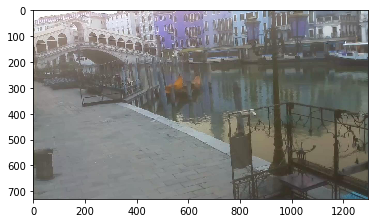

segment: {'secs': 12.0, 'segment': 'https://cdn-001.whatsupcams.com/hls/it_venezia01-26775.ts'}


In [21]:
for idx in range(3):
    venice_response = requests.get(venice_chunk_url)
    venice_chunklist = venice_response.text
    segments = m3u8_segments(venice_chunklist, venice_base)
    print("loop idx : {}, segments:{} ".format(idx, len(segments)))

    for segment in segments:
        # only get the first frame 
        display_frame(segment)
        #cap = cv2.VideoCapture(segment['segment'])
        print("segment:", segment)

    #print("last wait:", last_secs )
    #time.sleep(last_secs/2)
        

    # break down frame into chunks


# extracting caltrans 

- extract the first level of m3u8 
- has resolution of 

## Getting to the cal trans camera data

 - get to a camera page: http://cwwp2.dot.ca.gov/vm/iframemap.htm
 - select a camera from the map. 
 - select 'Open this camera in a bookmark-friendly format"
 - grap URL of opened page : http://cwwp2.dot.ca.gov/vm/loc/d4/tv388sr1justsouthofpresidiotunnel.htm
 - fetch page source (wget) 
 - search  source for extentions m3u8
     - http:\/\/wzmedia.dot.ca.gov\/D4\/N1_at_Presidio_Tunnel.stream\/playlist.m3u8
 - contents of file, describing encoding.:
```
#EXTM3U
#EXT-X-VERSION:4
#EXT-X-STREAM-INF:BANDWIDTH=270385,CODECS="avc1.640028",RESOLUTION=853x480
chunklist_w26198038.m3u8
```
 - Build url using base_of+ .m3u8 replace file with file from contents (chunklist..) : 
   - http://wzmedia.dot.ca.gov/D4/N1_at_Presidio_Tunnel.stream/chunklist_w26198038.m3u8
 - wget the built url.
 ```
#EXTM3U
#EXT-X-VERSION:4
#EXT-X-TARGETDURATION:11
#EXT-X-MEDIA-SEQUENCE:13628
#EXTINF:8.667,
media_w26198038_13628.ts
#EXTINF:10.6,
media_w26198038_13629.ts
#EXTINF:10.799,
media_w26198038_13630.ts
```

In conjuntion with the base the media* is what is being looked for.

wget http://wzmedia.dot.ca.gov:1935/D3/80_applegate.stream/chunklist_w26198038.m3u8



In [8]:
url = "http://cwwp2.dot.ca.gov/vm/loc/d4/tve73us101spenceravenue.htm"
url = "http://cwwp2.dot.ca.gov/vm/loc/d4/tv388sr1justsouthofpresidiotunnel.htm"

html_response = requests.get(url)

In [9]:
# find media index file, derive the base url - Only need todo this once.
encoded_links = re.findall('\"http\S*m3u8\"',html_response.text)
master_m3u8 = [link.replace("\/","/") for link in encoded_links]
assert len(master_m3u8) == 1, "can only handle 1 master"
cal_playlist_level0 = master_m3u8[0][1:-1]
cal_base = extract_base(cal_playlist_level0)
print("basePath:", cal_base)

# need an to go down another level of index
cal_level0 = requests.get(cal_playlist_level0)
cal_chunklist_level0 = cal_level0.text
segments_level0 = m3u8_segments(cal_chunklist_level0, cal_base)
cal_playlist_level1 = segments_level0[0]['segment']
print("level1", cal_playlist_level1 )

basePath: http://wzmedia.dot.ca.gov/D4/N1_at_Presidio_Tunnel.stream/
level1 http://wzmedia.dot.ca.gov/D4/N1_at_Presidio_Tunnel.stream/chunklist_w655247286.m3u8


In [18]:
# loop to fetch new elements
for idx in range(3):
    cal_response = requests.get(cal_playlist_level1)
    cal_chunklist = cal_response.text
    segments = m3u8_segments(cal_chunklist, cal_base)
    seg_count = 0
    for segment in segments:
        seg_count += 1
        display_frame(segment)
        wait_time = segment['secs']/3
        print("segment[{} of {} - sleep:{}]:\n\t{}".format(seg_count, len(segments), wait_time, segment))
        time.sleep(wait_time)

    #print("last wait:", last_secs )
    #time.sleep(last_secs/2)



KeyboardInterrupt: 

In [59]:
cal_chunklist

'#EXTM3U\n#EXT-X-VERSION:4\n#EXT-X-STREAM-INF:BANDWIDTH=111587,CODECS="avc1.4d0029",RESOLUTION=320x240\nchunklist_w2064379200.m3u8\n'

In [39]:
## repeat from here
r = requests.get(playlist_m3u8)
print(r.text)
chunks = [ele for ele in r.text.split("\n")[:-1] if ele[0]!="#"]
print(chunks)


#EXTM3U
#EXT-X-VERSION:4
#EXT-X-STREAM-INF:BANDWIDTH=110708,CODECS="avc1.4d0029",RESOLUTION=320x240
chunklist_w975991946.m3u8

['chunklist_w975991946.m3u8']


In [40]:
print(basePath + chunks[0])
r = requests.get(basePath + chunks[0])
#http://wzmedia.dot.ca.gov/D4/N101_at_Spencer_Av.stream/chunklist_w319930354.m3u8
chunk_text = r.text

http://wzmedia.dot.ca.gov/D4/N101_at_Spencer_Av.stream/chunklist_w975991946.m3u8


In [41]:
segments = m3u8_segments(chunk_text, basePath )
print(segments)

[{'secs': 10.677, 'segment': 'http://wzmedia.dot.ca.gov/D4/N101_at_Spencer_Av.stream/media_w975991946_15764.ts'}, {'secs': 9.61, 'segment': 'http://wzmedia.dot.ca.gov/D4/N101_at_Spencer_Av.stream/media_w975991946_15765.ts'}, {'secs': 9.609, 'segment': 'http://wzmedia.dot.ca.gov/D4/N101_at_Spencer_Av.stream/media_w975991946_15766.ts'}]


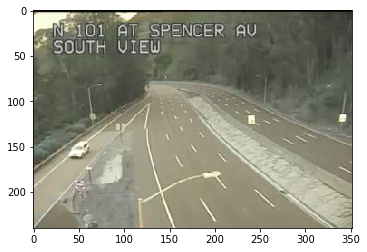

segment: {'secs': 9.609, 'segment': 'http://wzmedia.dot.ca.gov/D4/N101_at_Spencer_Av.stream/media_w975991946_15766.ts'}


In [42]:
for segment in segments:
    # only get the first frame 
    display_frame(segment)
    #cap = cv2.VideoCapture(segment['segment'])
    print("segment:", segment)



In [32]:
collect_segments("cal.ts", segments)

get segment: {'secs': 9.61, 'segment': 'http://wzmedia.dot.ca.gov/D4/N1_at_Presidio_Tunnel.stream/media_w1575170799_4635.ts'}
get segment: {'secs': 10.677, 'segment': 'http://wzmedia.dot.ca.gov/D4/N1_at_Presidio_Tunnel.stream/media_w1575170799_4636.ts'}
get segment: {'secs': 9.609, 'segment': 'http://wzmedia.dot.ca.gov/D4/N1_at_Presidio_Tunnel.stream/media_w1575170799_4637.ts'}


'cal.ts'

## polar bear - used chome to find chunkUrl

san diego zoo polar bear : https://zoo.sandiegozoo.org/cams/polar-cam

Had to look a the network trace Chrome to find the .m3u8 url. 




In [11]:
chunkUrl = "https://polarplunge.hls.camzonecdn.com/CamzoneStreams/polarplunge/chunklist.m3u8"

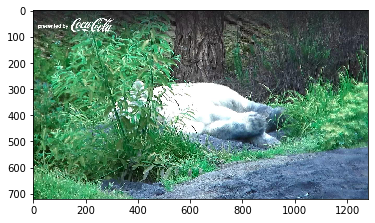

segment[3]:{'secs': 4.133, 'segment': 'https://polarplunge.hls.camzonecdn.com/CamzoneStreams/polarplunge/media_3065.ts'}


In [17]:
polar_bpath = extract_base(chunkUrl)
print("polar bear base path:", polar_bpath)

for idx in range(4):
    chunks_response = requests.get(chunkUrl)
    segments = m3u8_segments(chunks_response.text, polar_bpath )
    for segment in segments:
        # only get the first frame 
        display_frame(segment)
        #cap = cv2.VideoCapture(segment['segment'])
        print("segment[{}]:{}".format(idx, segment))
    time.sleep(5)



#m3u8_master = m3u8.loads(r.text)
#m3u8_master.dumps()



In [ ]:
r = requests.get(chunks[0])
print(r.text)

In [ ]:
m3u8

In [ ]:
r = requests.get("https://zoo.sandiegozoo.org/cams/polar-cam")